In [1]:
import numpy as np
import pandas as pd
import urllib
import requests
import json
import io
import datetime
import pickle
import joblib

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from matplotlib import pyplot as plt

In [2]:
org = pd.read_csv('data.csv')

In [3]:
org

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2249,Verkehrsunfälle,Verletzte und Getötete,2000,200008,647.0,NaN,-13.04,NaN,584.0
2250,Verkehrsunfälle,Verletzte und Getötete,2000,200009,675.0,NaN,4.33,NaN,594.0
2251,Verkehrsunfälle,Verletzte und Getötete,2000,200010,615.0,NaN,-8.89,NaN,596.0
2252,Verkehrsunfälle,Verletzte und Getötete,2000,200011,578.0,NaN,-6.02,NaN,594.0


In [4]:
org['MONATSZAHL'].unique()

array(['Alkoholunfälle', 'Fluchtunfälle', 'Verkehrsunfälle'], dtype=object)

### Processing records of each category and visualizing trends

In [5]:
def plot_time_series(df, category, color):
    fig = plt.figure(figsize=(10,4), constrained_layout=True)
    ax = plt.subplot(111)
    ax.plot(df['PERIOD'], df['WERT'], color=color)
    plt.title(f'{category}')
    plt.xlabel('Year')
    plt.ylabel('Num accidents')

    ax.spines[['right', 'top']].set_visible(False)
    plt.xticks(df['PERIOD'].to_numpy()[::24], labels=df['JAHR'][::24])
    plt.savefig(f'images/{category}_timeseries.png', dpi=300)

In [6]:
def process_per_category(df_full, category):
    df = df_full[df_full['JAHR'] <= 2021]
    df = df[df['MONATSZAHL'] == category]
    df = df[df['AUSPRAEGUNG'] == 'insgesamt']
    df = df[df['MONAT'] != 'Summe']
    
    df['PERIOD'] = pd.to_datetime(df['MONAT'], format='%Y%m')
    df = df.sort_values(by='PERIOD')
    return df

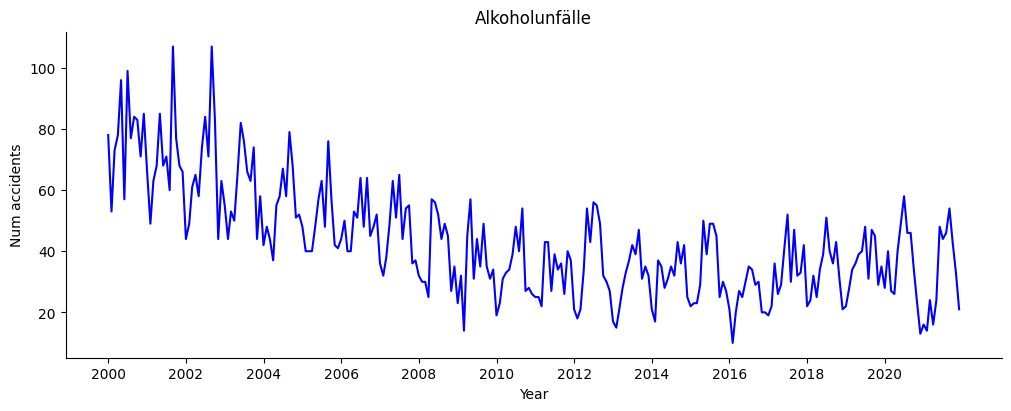

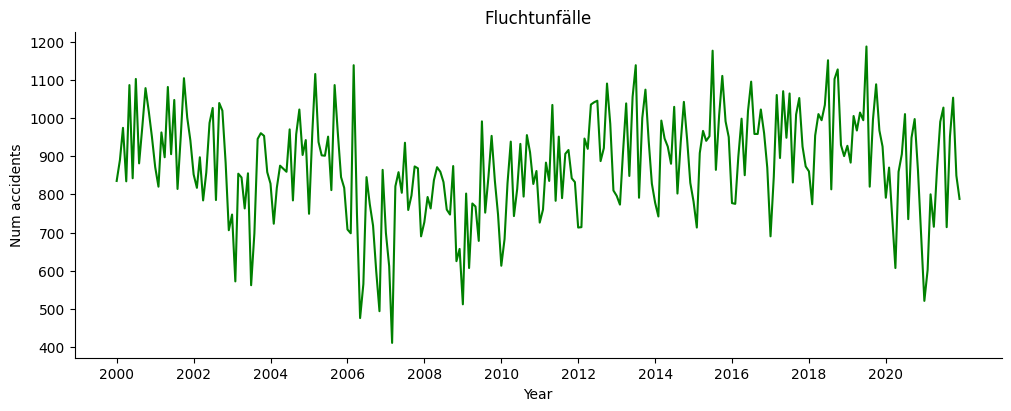

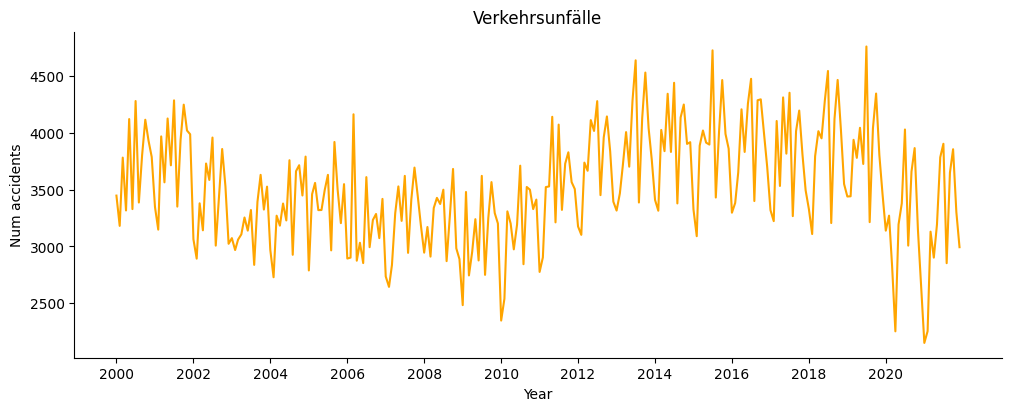

In [7]:
dfs = {}
colors = ['blue', 'green', 'orange']
for cat, color in zip(org['MONATSZAHL'].unique(), colors):
    dfs[cat] = process_per_category(org, cat)
    plot_time_series(dfs[cat], cat, color=color)

### Developing a forecast model for Alkoholunfälle category

In [8]:
df = dfs['Alkoholunfälle']

In [9]:
### Splitting train and test data
train_val = df[df['PERIOD'] < pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
test = df[df['PERIOD'] >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')]

### Splitting validation data for grid search of hyperparameters
val = train_val[train_val['PERIOD'] >= pd.to_datetime("2017-01-01", format='%Y-%m-%d')]
train = train_val[train_val['PERIOD'] < pd.to_datetime("2017-01-01", format='%Y-%m-%d')]

In [10]:
train

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,PERIOD
310,Alkoholunfälle,insgesamt,2000,200001,78.0,NaN,NaN,NaN,78.0,2000-01-01
311,Alkoholunfälle,insgesamt,2000,200002,53.0,NaN,-32.05,NaN,66.0,2000-02-01
312,Alkoholunfälle,insgesamt,2000,200003,73.0,NaN,37.74,NaN,68.0,2000-03-01
313,Alkoholunfälle,insgesamt,2000,200004,78.0,NaN,6.85,NaN,71.0,2000-04-01
314,Alkoholunfälle,insgesamt,2000,200005,96.0,NaN,23.08,NaN,76.0,2000-05-01
...,...,...,...,...,...,...,...,...,...,...
110,Alkoholunfälle,insgesamt,2016,201608,34.0,49.0,-2.86,-30.61,27.0,2016-08-01
111,Alkoholunfälle,insgesamt,2016,201609,29.0,45.0,-14.71,-35.56,26.0,2016-09-01
112,Alkoholunfälle,insgesamt,2016,201610,30.0,25.0,3.45,20.00,27.0,2016-10-01
113,Alkoholunfälle,insgesamt,2016,201611,20.0,30.0,-33.33,-33.33,26.0,2016-11-01


In [11]:
test.shape

(12, 10)

In [12]:
val.shape

(48, 10)

### Autoregressive Moving Average Model

In [13]:
y = train['WERT']
ARMAmodel = SARIMAX(y, order = (1, 0, 1))
ARMAmodel = ARMAmodel.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.92619D+00    |proj g|=  5.55532D-03

At iterate    5    f=  3.92486D+00    |proj g|=  1.01775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   6.320D-07   3.925D+00
  F =   3.9248365351781929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [14]:
y_pred_ARMA = ARMAmodel.get_forecast(len(val))

/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
y_pred_df_ARMA = y_pred_ARMA.conf_int(alpha = 0.05) 
y_pred_df_ARMA["Predictions"] = ARMAmodel.predict(start = y_pred_df_ARMA.index[0], end = y_pred_df_ARMA.index[-1])

/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
y_pred_df_ARMA['Predictions']

204    21.768462
205    21.577717
206    21.388643
207    21.201226
208    21.015451
209    20.831303
210    20.648770
211    20.467836
212    20.288487
213    20.110710
214    19.934490
215    19.759815
216    19.586670
217    19.415043
218    19.244919
219    19.076286
220    18.909131
221    18.743440
222    18.579201
223    18.416402
224    18.255029
225    18.095069
226    17.936512
227    17.779344
228    17.623553
229    17.469127
230    17.316055
231    17.164323
232    17.013921
233    16.864837
234    16.717060
235    16.570577
236    16.425378
237    16.281451
238    16.138786
239    15.997370
240    15.857194
241    15.718245
242    15.580515
243    15.443991
244    15.308664
245    15.174522
246    15.041556
247    14.909755
248    14.779108
249    14.649607
250    14.521240
251    14.393998
Name: Predictions, dtype: float64

### Visualizing predictions of ARMA model
The model predictions are off from ground truth values

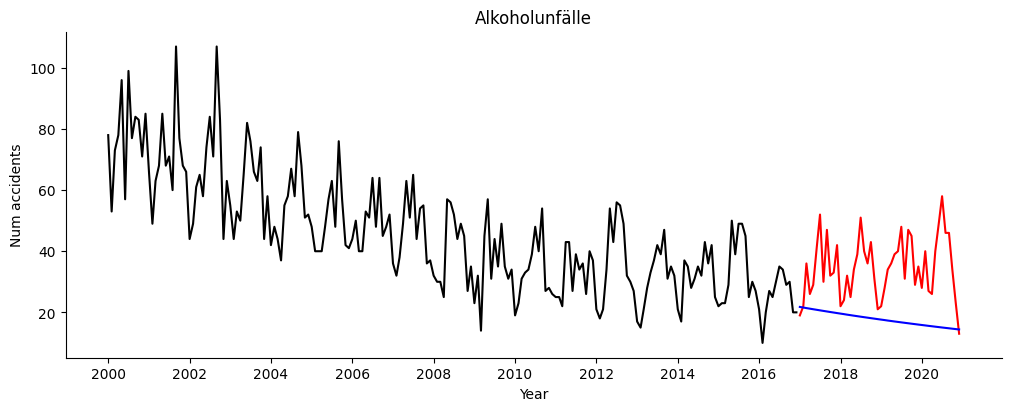

In [17]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
ax = plt.subplot(111)
ax.plot(train['PERIOD'], train['WERT'], color='black')
ax.plot(val['PERIOD'], val['WERT'], color='red')
ax.plot(val['PERIOD'], y_pred_df_ARMA['Predictions'], color='blue')
plt.title('Alkoholunfälle')
plt.xlabel('Year')
plt.ylabel('Num accidents')

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(df['PERIOD'].to_numpy()[::24], labels=df['JAHR'][::24])
plt.savefig('images/predictions_ARMA_timeseries.png', dpi=300)
# plt.plot(train['PERIOD'], train['WERT'], color='black')
# plt.plot(val['PERIOD'], val['WERT'], color='red')
# plt.plot(val['PERIOD'], y_pred_df_ARMA['Predictions'], color='green')

### Autoregressive Integrated Moving Average Model (ARIMA)

In [18]:
y = train['WERT']
model = ARIMA(y, order=(5,1,7))
model_ARIMA = model.fit()

/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
y_pred_ARIMA = model_ARIMA.get_forecast(len(val))
y_pred_df_ARIMA = y_pred_ARIMA.conf_int(alpha = 0.05) 
y_pred_df_ARIMA["Predictions"] = model_ARIMA.predict(start = y_pred_df_ARIMA.index[0], end = y_pred_df_ARIMA.index[-1])

/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Visualizing ground truth and predictions of both ARMA and ARIMA models

ARIMA model (yellow) performs better than the ARMA model (green).

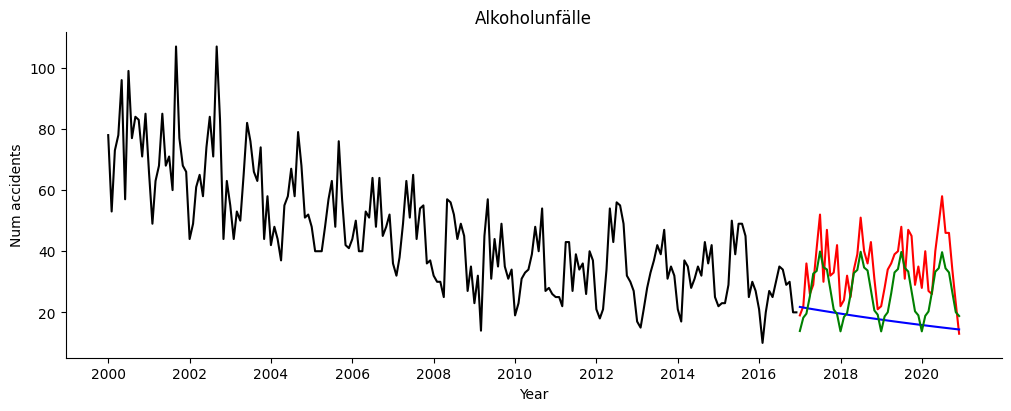

In [20]:
fig = plt.figure(figsize=(10,4), constrained_layout=True)
ax = plt.subplot(111)
ax.plot(train['PERIOD'], train['WERT'], color='black')
ax.plot(val['PERIOD'], val['WERT'], color='red')
ax.plot(val['PERIOD'], y_pred_df_ARMA['Predictions'], color='blue')
ax.plot(val['PERIOD'], y_pred_df_ARIMA['Predictions'], color='green')
plt.title('Alkoholunfälle')
plt.xlabel('Year')
plt.ylabel('Num accidents')

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(df['PERIOD'].to_numpy()[::24], labels=df['JAHR'][::24])
plt.savefig('images/predictions_timeseries.png', dpi=300)

# plt.plot(train['PERIOD'], train['WERT'], color='black')
# plt.plot(val['PERIOD'], val['WERT'], color='red')
# plt.plot(val['PERIOD'], y_pred_df_ARMA['Predictions'], color='green')
# plt.plot(val['PERIOD'], y_pred_df_ARIMA['Predictions'], color='blue')

In [21]:
rmse_ARMA = sqrt(mean_squared_error(val['WERT'], y_pred_df_ARMA["Predictions"]))
rmse_ARIMA = sqrt(mean_squared_error(val['WERT'], y_pred_df_ARIMA["Predictions"]))
print(f'ARMA rmse: {rmse_ARMA:.3f}, ARIMA rmse: {rmse_ARIMA:.3f}')

ARMA rmse: 19.910, ARIMA rmse: 10.517


### Saving model and testing saved model

In [ ]:
filename = 'forecast.pkl'
pickle.dump(model_ARIMA, open(filename, 'wb'))

In [ ]:
# loaded_model = pickle.load(open(filename, 'rb'))

In [11]:
loaded_model = joblib.load('forecast.pkl')

In [12]:
y_pred_ARIMA = loaded_model.get_forecast(len(test.index))
y_pred_df_ARIMA = y_pred_ARIMA.conf_int(alpha = 0.05) 
y_pred_df_ARIMA["Predictions"] = loaded_model.predict(start = y_pred_df_ARIMA.index[0], end = y_pred_df_ARIMA.index[-1])

/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [55]:
raw_data = '{"year": 2021, "month": 10}'

In [56]:
year = json.loads(raw_data)['year']
month = json.loads(raw_data)['month']

num_years = int(year) - 2021
n = int(month) + (12 * num_years)
print(n)

y_pred = loaded_model.get_forecast(n)
y_pred_df_ARIMA = y_pred.conf_int(alpha = 0.05) 
y_pred_df_ARIMA["Predictions"] = loaded_model.predict(start = y_pred_df_ARIMA.index[0], end = y_pred_df_ARIMA.index[-1])
prediction = y_pred_df_ARIMA['Predictions'].tolist()[-1]

10


/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/nishu/opt/anaconda3/envs/dps_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [57]:
prediction

38.71309793849907